In [1]:
from google.colab import drive  
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
path = "/content/drive/My Drive/Khoa Luan/"

In [3]:
import pickle
import pandas as pd
df = pd.read_csv(path+"NTC_SV/NTC_SV_train.csv")
df = df.dropna()

In [4]:
data = df.review.to_list()
label = df.label.to_list()

In [5]:
!pip install -q keras-bert==0.85.0
!pip install -q keras-rectified-adam

In [6]:
!wget -q https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
!unzip -o multi_cased_L-12_H-768_A-12.zip

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [7]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [8]:
pip install keras==2.3.1

     |████████████████████████████████| 378kB 5.3MB/s 
ERROR: keras-bert 0.85.0 has requirement Keras>=2.4.3, but you'll have keras 2.3.1 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [9]:
import codecs
import tensorflow as tf
import keras
import os
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
import numpy as np

Using TensorFlow backend.


In [10]:
SEQ_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5

In [11]:
pretrained_path = 'multi_cased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [12]:
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    trainable=True,
    seq_len=SEQ_LEN,
    output_layer_num=4
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
token_dict = {}
with codecs.open(vocab_path, 'rb','utf-8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

In [14]:
from keras_bert import Tokenizer
tokenizer = Tokenizer(token_dict,cased=True)

In [15]:
from keras_bert.layers import Extract
from keras.regularizers import l1

In [16]:
inputs = model.inputs[:2]
newout = Extract(index=0)(model.output)
newout = keras.layers.Dense(768,activation='relu')(newout)
outputs = keras.layers.Dense(units=1, activation='sigmoid')(newout)
model = keras.models.Model(inputs, outputs)
model.compile(
  RAdam(learning_rate=LR),
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

In [18]:
from sklearn.model_selection import train_test_split
def load_data(data, sentiments):
    global tokenizer
    indices = []
    for text in data:
      ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
      indices.append(ids)

    return [indices, np.zeros_like(indices)], np.array(sentiments)

In [ ]:
data_train,data_valid,label_train,label_valid = train_test_split(data,label,test_size=0.15,random_state=48)

In [ ]:
X_train,Y_train = load_data(data_train,label_train)
X_valid,Y_valid = load_data(data_valid,label_valid)

In [19]:
test = pd.read_csv(path+'NTC_SV/NTC_SV_test.csv')
test = test.dropna()
data_test = test.review.tolist()
label_test = test.label.tolist()
X_test,Y_test = load_data(data_test,label_test)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(path+'256_checkpoint_foody.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train,Y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose = 1,validation_data=[X_valid,Y_valid],callbacks=callbacks_list) 

In [20]:
model.load_weights(path+'256_checkpoint_foody.h5')

In [21]:
y_pred = np.round(model.predict(X_test))

In [22]:
from sklearn.metrics import precision_score,recall_score,f1_score
print(precision_score(Y_test,y_pred))
print(recall_score(Y_test,y_pred))
print(f1_score(Y_test,y_pred))

0.8813273340832396
0.9402
0.9098122701761178


In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels=[0,1]
cn = confusion_matrix(Y_test,y_pred,labels=[0,1])

In [31]:
#@title plot confusion matrix
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          target_names=None,
                          path_file='1.svg'):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_file,format='svg')
    plt.show()
    

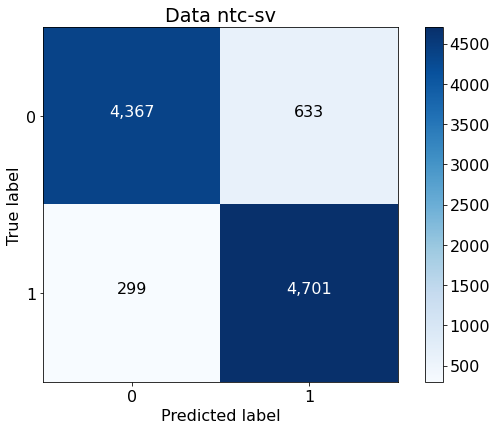

In [36]:
plot_confusion_matrix(cn,title='Data ntc-sv',normalize=False,target_names=labels,path_file=path+'bert_base_ntcsv_cm.svg')

In [ ]:
for i in range(100):
  if y_pred[i]!=Y_test[i]:
    print(y_pred[i],Y_test[i])
    print(data_test[i])

[1.] 0
mới mở_cửa mà mấy đứa trực từ vào ngồi chờ cho đỡ nắng nữa đi đúng positive đợt khuyến_mãi nên rẻ positive nữa keke cơ_mà không phải vị nào cũng ngon positive bạn mình ăn vị có màu mint mà không phải mint ăn như xà_phòng nói_chung thích positive nhất socola thôi còn nữa đi ăn mở_hàng đầu ngày mà không phải cái gì cũng có đâu sự chuẩn_bị không được positive kĩ cho lắm
[1.] 0
nước uống đây lạc nhách gọi ly đào đá xay mà cứ như uống nước_đá pha kem vậy thôi có được positive tí_ti hương đào sushi thì ngon positive rồi vì đây là kết_hợp với quán bento cũ nhưng_mà giá_cả sushi lại nâng cao hơn gấp đôi so với giá cũ khi bán online nếu vậy thà bán onl còn hơn có quán_xá đàng_hoàng
[1.] 0
cơm đây ngon positive giá mềm positive mỗi_tội lúc trước nhân_viên phục_vụ tốt positive hơn positive bây_giờ đợi lâu
[1.] 0
trà sữa đây rất ngon positive trà tươi positive cũng vậy trà sữa không bị negative ngọt quá như những chỗ khác chị chủ quán cũng rất vui_tính positive và thân_thiện positive
[1.] 0